In [31]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Beyond Single Runs: Tendency Analysis of Non-Deterministic Eval Tasks



<table align="left">

</table>

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapplied-ai-engineering-samples%2Fmain%2Fgenai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering-samples/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Alejandro Ballesta](https://www.linkedin.com/in/alejandroballestae/) |

**_NOTE_**: This notebook has been tested in the following environment:

* Python version >= 3.10

## Overview

This notebook explores the application of statistical methods to gain insights into the behavior of the **Vertex AI Python SDK for Gen AI Evaluation Service** for generated answers during **Question Answering** (QA) tasks. Due to the inherent variability, non-deterministic or probabilistic outcomes in these tasks, relying on a single execution may not provide a comprehensive understanding of the real performance.


We'll delve into techniques to aggregate and analyze results from multiple runs, enabling us to:
* **Identifying the problem:** running multiple tests over the same data to understand the non-deterministic outputs
* **Setting up a more reliable approach:** using the same pair of questions and contexts, we will use the generated answers of two different models (ex. Gemini 1.5 vs Gemini Flash) as an input to our method and demonstrate an extensive methodology to derive better conclusions
* **Running the experiment:** for each model, we will run the QA Gen AI Evaluation Service method 40 times to extract multiple performance metrics
* **Quantifying Performance:** we will calculate key statistical measures like mean, median, and standard deviation to gauge central tendency and variability across executions.
* **Identifying Performance:** In this section, using the statistical measures calculated, we will visualize the distributions of each metric overlapping the results of both models in the same chart
* **Assessing Confidence:** applying confidence intervals or hypothesis testing we will draw statistically sound conclusions about the performance of eval tasks.
By leveraging these statistical tools, we aim to move beyond single-run observations and gain a more robust understanding of the true behavior and capabilities of these non-deterministic tasks.
* **Comparing Results:** we will plot a radar chart and determine which model is better for our own goals

**Note:** The purpose of this analysis is not to have a completely statistical (since we are making a lot of assumptions) proof, but to gain a more holistic view of the architecture's performance


## Getting Started

### Install Vertex AI SDK for Gen AI Evaluation Service

In [32]:
%pip install --upgrade --user --quiet google-cloud-aiplatform[evaluation]
%pip install --quiet --upgrade nest_asyncio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Restart runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [33]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

In [34]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

In [36]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "[your-location]"  # @param {type:"string"}
PROJECT_ID = "golf-demo-abr"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [37]:
# General
from IPython.display import display, Markdown, HTML
import logging
import nest_asyncio
import warnings

# Main
from vertexai.preview.evaluation import EvalTask
import pandas as pd

### Library settings

In [38]:
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)
nest_asyncio.apply()
warnings.filterwarnings("ignore")

# **Identifying the problem**
In this section we are going to run 2 independent evaluation tasks and gather evidence of different results under the same following conditions:
* **Questions:** set of 5 random questions (same questions for each test)
* **Retrieved context:** for the purpose of this notebook we assume that the context is retrieved with any particular method
* **Generated answers:** we are going to use the answers already presented on the Gen AI Evaluation Service Getting Started notebook ([evaluate_rag_rapid_eval](https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluate_rag_rapid_evaluation_sdk.ipynb))


## Prepare Dataset

To evaluate the RAG generated answers, the evaluation dataset is required to contain the following fields:

* Question
* Context
* RAG Generated Answer

In [39]:
questions = [
    "Which part of the brain does short-term memory seem to rely on?",
    "What provided the Roman senate with exuberance?",
    "What area did the Hasan-jalalians command?",
    "How many pencils could be made from the carbon in an average adult human body?"
]

retrieved_contexts = [
    "Short-term memory is supported by transient patterns of neuronal communication, dependent on regions of the frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe. Long-term memory, on the other hand, is maintained by more stable and permanent changes in neural connections widely spread throughout the brain. The hippocampus is essential (for learning new information) to the consolidation of information from short-term to long-term memory, although it does not seem to store information itself. Without the hippocampus, new memories are unable to be stored into long-term memory, as learned from patient Henry Molaison after removal of both his hippocampi, and there will be a very short attention span. Furthermore, it may be involved in changing neural connections for a period of three months or more after the initial learning.",
    "In 62 BC, Pompey returned victorious from Asia. The Senate, elated by its successes against Catiline, refused to ratify the arrangements that Pompey had made. Pompey, in effect, became powerless. Thus, when Julius Caesar returned from a governorship in Spain in 61 BC, he found it easy to make an arrangement with Pompey. Caesar and Pompey, along with Crassus, established a private agreement, now known as the First Triumvirate. Under the agreement, Pompey's arrangements would be ratified. Caesar would be elected consul in 59 BC, and would then serve as governor of Gaul for five years. Crassus was promised a future consulship.",
    "The Seljuk Empire soon started to collapse. In the early 12th century, Armenian princes of the Zakarid noble family drove out the Seljuk Turks and established a semi-independent Armenian principality in Northern and Eastern Armenia, known as Zakarid Armenia, which lasted under the patronage of the Georgian Kingdom. The noble family of Orbelians shared control with the Zakarids in various parts of the country, especially in Syunik and Vayots Dzor, while the Armenian family of Hasan-Jalalians controlled provinces of Artsakh and Utik as the Kingdom of Artsakh.",
    "The average adult human body contains enough carbon to make about 900 pencils"
]

generated_answers = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 901"
]


eval_dataset = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers,
    }
)

## Select Metric and Define EvalTask


Choose from the following metrics for an evaluation task. For more information about the supported evaluation metrics and how to use each metric, please see [Evaluation methods and metrics](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval).

*   `question_answering_quality` (overall quality)
*   `question_answering_relevance`
*   `question_answering_helpfulness`
*   `fulfillment`

You can run evaluation for just one metric, or a combination of metrics. For example, we create an `EvalTask` named `answer_eval_task` with all the QA-related metrics to compute all the metrics in one eval run as follows:

In [40]:
answer_eval_task = EvalTask(
    dataset=eval_dataset,
    metrics=[
        "question_answering_quality",
        "coherence",
        "fluency",
        "verbosity"
    ],
    experiment="rag-eval-01",
)

## Run Evaluation

In [41]:
first_result = answer_eval_task.evaluate()
second_result = answer_eval_task.evaluate()

Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-eval-01-944b9832-bbd7-4dc7-851d-75ef391183a7 to Experiment: rag-eval-01


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.459368749987334 seconds


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-eval-01-190de896-e82c-439e-9534-70bb58f48ce0 to Experiment: rag-eval-01


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.434100624988787 seconds


In [42]:
first_result.summary_metrics

{'row_count': 4,
 'question_answering_quality/mean': np.float64(3.25),
 'question_answering_quality/std': np.float64(1.2583057392117916),
 'coherence/mean': np.float64(2.75),
 'coherence/std': np.float64(1.707825127659933),
 'fluency/mean': np.float64(3.25),
 'fluency/std': np.float64(1.5),
 'verbosity/mean': np.float64(-1.0),
 'verbosity/std': np.float64(0.816496580927726)}

#Let's compare the results of running the same experiment twice

In [43]:
first_df = pd.DataFrame(first_result.metrics_table)
second_df = pd.DataFrame(second_result.metrics_table)

first_df = first_df.add_prefix('first_')
second_df = second_df.add_prefix('second_')

result = pd.concat([first_df, second_df], axis=1)
result[["first_question_answering_quality/score","second_question_answering_quality/score"]]


,first_question_answering_quality/score,second_question_answering_quality/score
0,3.0,3.0
1,3.0,3.0
2,5.0,5.0
3,2.0,3.0


You are probably seeing different results (row 3) for at least one row; if not, try again
:)

# **Setting up a more reliable approach**

if you are comparing two differnt architectures (Ex, Gemini 1.5 generations vs Gemini Flash generations), it's recommended to use sample distributions to understand the perfomance of each approach.

Let's see one example


## Modal A vs Model B set up

In [44]:
generated_answers_modal_a = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 900 pencils could be made from an adult human body"
]

generated_answers_model_b = [
    "frontal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded Vayots Dzor",
    "I would guess 901"
]

eval_dataset_model_a = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_modal_a,
    }
)
eval_dataset_model_b = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_model_b,
    }
)

#**Running the experiment**

Once the answers have been generated, let's run 40 identical experiments for each approach

In [45]:
#Let's first define the metrics we are going to use

metrics = ["question_answering_quality",
        "coherence",
        "fluency",
        "verbosity"]
n=40

In [46]:
#Model A - 40 iteration evaluation

model_a_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_model_a,
      metrics=metrics,
      experiment=f"rag-model-a-1-5-eval-{i}",
  )
  model_a_results.append(answer_eval_task.evaluate().summary_metrics)

running experiment 0-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-0-d7cd6c5d-d978-457b-ab06-1f7a5f9abba8 to Experiment: rag-model-a-1-5-eval-0


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.313268708065152 seconds


running experiment 1-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-1-724f185e-9167-4a7f-b1c6-a40bbb9923e7 to Experiment: rag-model-a-1-5-eval-1


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.117535875062458 seconds


running experiment 2-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-2-b701d458-74a2-47ff-bb2a-d9e69113cc7b to Experiment: rag-model-a-1-5-eval-2


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.212710915948264 seconds


running experiment 3-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-3-efceeb5c-d037-4497-8300-d95426df541b to Experiment: rag-model-a-1-5-eval-3


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.159309083013795 seconds


running experiment 4-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-4-88d0588d-6409-40de-88e2-73c20e970722 to Experiment: rag-model-a-1-5-eval-4


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.610690042027272 seconds


running experiment 5-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-5-6ab25c86-3ea7-48ea-9a15-e0e84bc3c3e2 to Experiment: rag-model-a-1-5-eval-5


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.962542457971722 seconds


running experiment 6-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-6-665fa051-a4a1-48be-9698-2e9a2e0f6fee to Experiment: rag-model-a-1-5-eval-6


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.554338874993846 seconds


running experiment 7-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-7-3c27680d-f226-4a0e-bcc1-e6b2befe5d60 to Experiment: rag-model-a-1-5-eval-7


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.592433207901195 seconds


running experiment 8-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-8-febdf483-b20a-4ffa-8a3c-4aaed30f178a to Experiment: rag-model-a-1-5-eval-8


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.013199833920226 seconds


running experiment 9-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-9-e405ef9b-0b29-4344-a3f6-351f4b3a093a to Experiment: rag-model-a-1-5-eval-9


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.982163332984783 seconds


running experiment 10-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-10-787e6ac1-266a-488f-8d66-2eee432aaba4 to Experiment: rag-model-a-1-5-eval-10


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.98103295895271 seconds


running experiment 11-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-11-720c5bf2-cb49-4c22-9afb-98d962ac2f54 to Experiment: rag-model-a-1-5-eval-11


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.104357082978822 seconds


running experiment 12-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-12-6d0774e2-409a-4dbc-af0f-f7359236bf57 to Experiment: rag-model-a-1-5-eval-12


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:20<00:00,  1.27s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.36693270795513 seconds


running experiment 13-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-13-636b7f73-9c38-4cf7-b4e3-d52c78235c10 to Experiment: rag-model-a-1-5-eval-13


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.473263832973316 seconds


running experiment 14-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-14-a130b1cb-693f-4ec1-a088-cc33044bd467 to Experiment: rag-model-a-1-5-eval-14


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.585479874978773 seconds


running experiment 15-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-15-fc0c5806-dc45-4a9b-b2db-ed2d471691c3 to Experiment: rag-model-a-1-5-eval-15


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.760829958016984 seconds


running experiment 16-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-16-f4b1035c-c535-4622-b5c0-23cf3ca8580b to Experiment: rag-model-a-1-5-eval-16


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.61736154195387 seconds


running experiment 17-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-17-733b3d93-94e4-4aaa-a221-dabf3cf4c324 to Experiment: rag-model-a-1-5-eval-17


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.245183582999744 seconds


running experiment 18-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-18-18e093c4-38b7-4b7c-a3e2-629c21d8ea20 to Experiment: rag-model-a-1-5-eval-18


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.56606633402407 seconds


running experiment 19-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-19-6633f7d8-79c5-40fa-86b4-01a0fb2ca06b to Experiment: rag-model-a-1-5-eval-19


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.624635791988112 seconds


running experiment 20-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-20-78b7c159-2253-46ea-9433-ae93a9ce9c5a to Experiment: rag-model-a-1-5-eval-20


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.537928459001705 seconds


running experiment 21-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-21-11be0acb-f574-415c-99fc-676bf12dfe74 to Experiment: rag-model-a-1-5-eval-21


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.24s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.78748945798725 seconds


running experiment 22-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-22-2809b17d-8231-4109-9810-3751a65a48f5 to Experiment: rag-model-a-1-5-eval-22


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.929503875086084 seconds


running experiment 23-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-23-5c0f2c24-adb2-4953-bd2e-9f580c79983c to Experiment: rag-model-a-1-5-eval-23


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.61105491698254 seconds


running experiment 24-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-24-60947854-4095-4f56-867e-9089689d1100 to Experiment: rag-model-a-1-5-eval-24


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.517649041023105 seconds


running experiment 25-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-25-3f989176-ac88-46c4-90ba-1fc68d4b5d86 to Experiment: rag-model-a-1-5-eval-25


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.973284000065178 seconds


running experiment 26-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-26-7dc92eb9-c2c0-4640-ba1e-8d889a499378 to Experiment: rag-model-a-1-5-eval-26


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.073825292056426 seconds


running experiment 27-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-27-b88a3023-d1b4-4a81-ae97-34fe78bc1d13 to Experiment: rag-model-a-1-5-eval-27


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.001063250005245 seconds


running experiment 28-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-28-35f57416-65aa-497e-8edb-4e481f517b89 to Experiment: rag-model-a-1-5-eval-28


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.98658508399967 seconds


running experiment 29-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-29-54efcd4a-eed9-4694-9da9-7a80754fa1bb to Experiment: rag-model-a-1-5-eval-29


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.944491958012804 seconds


running experiment 30-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-30-998dfc21-0696-4c14-b864-0ffaca7e9953 to Experiment: rag-model-a-1-5-eval-30


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.938006917014718 seconds


running experiment 31-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-31-53b5710d-4284-4464-98d6-efc1a368f453 to Experiment: rag-model-a-1-5-eval-31


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.172397500020452 seconds


running experiment 32-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-32-cb336749-1623-47ab-8518-0fd7f858858a to Experiment: rag-model-a-1-5-eval-32


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.668965499964543 seconds


running experiment 33-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-33-a31d6fd3-8f0d-4606-b236-b7d213f9bb82 to Experiment: rag-model-a-1-5-eval-33


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.58719320804812 seconds


running experiment 34-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-34-f74bd033-85c5-49c5-a760-2df2cadc10cf to Experiment: rag-model-a-1-5-eval-34


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.42217816610355 seconds


running experiment 35-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-35-dd7186fc-39ae-4ccd-af95-84d18e6d31d7 to Experiment: rag-model-a-1-5-eval-35


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.20102287491318 seconds


running experiment 36-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-36-7fc24adf-5886-4aeb-a504-1e47eee19ebe to Experiment: rag-model-a-1-5-eval-36


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.23532974999398 seconds


running experiment 37-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-37-470c9ba9-ac69-4a12-904b-3e9a834bcc8e to Experiment: rag-model-a-1-5-eval-37


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.406745583983138 seconds


running experiment 38-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-38-bd6163a6-ff73-4e69-8df0-0eef3a3f8142 to Experiment: rag-model-a-1-5-eval-38


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.039564749924466 seconds


running experiment 39-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-39-aff0053f-88bb-4487-a272-d78d3e4e6c7e to Experiment: rag-model-a-1-5-eval-39


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.945419167052023 seconds


In [47]:
#Model B- 40 iteration evaluation

model_b_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_model_b,
      metrics=metrics,
      experiment=f"rag-model-b-eval-{i}",
  )
  model_b_results.append(answer_eval_task.evaluate().summary_metrics)

running experiment 0-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-0-2fda59e8-9223-4a0b-aecf-e377e61b0a33 to Experiment: rag-model-b-eval-0


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.77122162503656 seconds


running experiment 1-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-1-ccf1e142-1121-4b89-afd8-16588fe08305 to Experiment: rag-model-b-eval-1


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.978554541012272 seconds


running experiment 2-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-2-366ec1b3-a46a-41bb-a542-10e0f4a727ee to Experiment: rag-model-b-eval-2


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.554658707929775 seconds


running experiment 3-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-3-40380a0d-bb51-423d-8c4c-4a9cbf904bca to Experiment: rag-model-b-eval-3


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.940328749944456 seconds


running experiment 4-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-4-63ec902f-726e-4368-b0ed-7a4afbd303b1 to Experiment: rag-model-b-eval-4


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.746626790962182 seconds


running experiment 5-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-5-54c197f7-4bf7-468c-810b-2667a6e17fca to Experiment: rag-model-b-eval-5


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.834777957992628 seconds


running experiment 6-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-6-d1b2918a-e3da-4969-a582-318bae37d7b1 to Experiment: rag-model-b-eval-6


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.45790391601622 seconds


running experiment 7-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-7-b6ace2da-177a-4717-b727-a012e3c1fa34 to Experiment: rag-model-b-eval-7


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.81904129195027 seconds


running experiment 8-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-8-86f3d9b3-5999-4e87-a1de-04d6bcf588b7 to Experiment: rag-model-b-eval-8


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.051123874960467 seconds


running experiment 9-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-9-49a92302-5a9e-4598-b8b9-fdd24ad1a3f4 to Experiment: rag-model-b-eval-9


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.135255333967507 seconds


running experiment 10-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-10-d9631301-98ce-4239-980c-e8274e51a994 to Experiment: rag-model-b-eval-10


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.322892540949397 seconds


running experiment 11-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-11-58bcb368-cbf2-42d1-ac43-e508d8dd92de to Experiment: rag-model-b-eval-11


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.18324037489947 seconds


running experiment 12-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-12-785fa92a-2b5f-46b6-91e6-36b2b45551fd to Experiment: rag-model-b-eval-12


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.440293916966766 seconds


running experiment 13-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-13-e715cd1b-8087-48f2-bfd2-55993784ec68 to Experiment: rag-model-b-eval-13


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:20<00:00,  1.29s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.614399040932767 seconds


running experiment 14-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-14-3533f47c-515d-42f8-b9e5-a3e12dd7ef19 to Experiment: rag-model-b-eval-14


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.259436166961677 seconds


running experiment 15-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-15-f001f94e-b42e-46fc-8edf-b5802f2756f6 to Experiment: rag-model-b-eval-15


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.796220792108215 seconds


running experiment 16-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-16-29c3cbe2-c853-4e86-83fe-95613f6a1d49 to Experiment: rag-model-b-eval-16


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.4147612079978 seconds


running experiment 17-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-17-93484f4a-a5b3-4571-8641-ccc8435d7a29 to Experiment: rag-model-b-eval-17


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.366774166934192 seconds


running experiment 18-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-18-3cde47ab-4e37-4415-9922-40648111f6d9 to Experiment: rag-model-b-eval-18


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.021799208014272 seconds


running experiment 19-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-19-509c99f2-ecfd-4fff-b879-2948d771f528 to Experiment: rag-model-b-eval-19


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.65168458293192 seconds


running experiment 20-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-20-b598c279-92fb-4dd5-b183-d29debae4ddb to Experiment: rag-model-b-eval-20


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.275130583904684 seconds


running experiment 21-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-21-f462a7a7-c6ac-4779-975d-2b9c14bbcda0 to Experiment: rag-model-b-eval-21


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.24s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.768629333935678 seconds


running experiment 22-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-22-dbbfbb21-02d4-4d41-8a6a-ea633a75ad6b to Experiment: rag-model-b-eval-22


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.736197583959438 seconds


running experiment 23-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-23-5bcc8ead-79a0-4637-a660-f2322e2bd2cf to Experiment: rag-model-b-eval-23


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.006270958925597 seconds


running experiment 24-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-24-e9182d71-01c5-4996-8993-a0cf1972252f to Experiment: rag-model-b-eval-24


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.60231275006663 seconds


running experiment 25-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-25-3c25f686-9004-48ba-bd1a-5f0cdeadd9b0 to Experiment: rag-model-b-eval-25


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.303280499996617 seconds


running experiment 26-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-26-9a27bee5-6d58-4961-955f-5c1c8e899033 to Experiment: rag-model-b-eval-26


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.571031833067536 seconds


running experiment 27-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-27-c2067acb-6425-4a63-bd38-608422addcb5 to Experiment: rag-model-b-eval-27


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.0223885839805 seconds


running experiment 28-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-28-6f70aae5-ddae-49a6-816c-a91a4514da5f to Experiment: rag-model-b-eval-28


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.648713416070677 seconds


running experiment 29-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-29-008ed218-1cc1-4d9c-a8b3-9e46c473d557 to Experiment: rag-model-b-eval-29


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.154637999949045 seconds


running experiment 30-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-30-7e1fb6d4-6a55-41a3-82f3-1a0454d0f6a3 to Experiment: rag-model-b-eval-30


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.210877332952805 seconds


running experiment 31-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-31-ea55f772-9569-4679-9869-3879269edb65 to Experiment: rag-model-b-eval-31


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.18349325004965 seconds


running experiment 32-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-32-d7d702cf-4b78-4198-9f39-574132808a0f to Experiment: rag-model-b-eval-32


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.719979666988365 seconds


running experiment 33-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-33-dac0bb7d-4d25-495e-bf61-d4651df66721 to Experiment: rag-model-b-eval-33


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.20s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.15915750002023 seconds


running experiment 34-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-34-badf6fbb-3af2-4e05-9379-83e8f39501e4 to Experiment: rag-model-b-eval-34


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:20<00:00,  1.27s/it]

All 16 metric requests are successfully computed.
Evaluation Took:20.27304320805706 seconds


running experiment 35-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-35-9ad2bc67-26f6-4bb7-bf9f-d6ee5c2c6787 to Experiment: rag-model-b-eval-35


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.013055208022706 seconds


running experiment 36-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-36-bda401f1-e7f8-4b6d-987e-26aa75d9c753 to Experiment: rag-model-b-eval-36


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.983837749925442 seconds


running experiment 37-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-37-af0590bb-d640-4e1c-8f68-23f241c22f07 to Experiment: rag-model-b-eval-37


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.920020499965176 seconds


running experiment 38-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-38-225acda4-c029-4fda-b258-b5d42bce7f6f to Experiment: rag-model-b-eval-38


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:18<00:00,  1.19s/it]

All 16 metric requests are successfully computed.
Evaluation Took:18.974551374907605 seconds


running experiment 39-------------------


Associating projects/1064411953270/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-39-5f4eae2d-ba09-4946-ad4a-391d0f00559c to Experiment: rag-model-b-eval-39


Computing metrics with a total of 16 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

All 16 metric requests are successfully computed.
Evaluation Took:19.483293167082593 seconds


#**Quantifying Performance**

##Get the mean of each summary metric for the 40 experiments

In [48]:
mean_metrics = [
    "question_answering_quality/mean",
    "coherence/mean",
    "fluency/mean",
    "verbosity/mean",
]

average_metrics_model_a = model_a_results_df[mean_metrics].mean()


average_metrics_model_a

question_answering_quality/mean    3.625000
coherence/mean                     3.293750
fluency/mean                       3.572938
verbosity/mean                    -0.793750
dtype: float64

In [49]:

average_metrics_model_b = model_b_results_df[mean_metrics].mean()


average_metrics_model_b

question_answering_quality/mean    3.15750
coherence/mean                     2.83125
fluency/mean                       3.46250
verbosity/mean                    -1.24375
dtype: float64

#**Identifying Performance and Assessing Confidence**

In this section we procced to create distribution charts for the mean of each metric evaluated per model/approach. We overlap the results of Model A on top of Model B outcomes and evidence the gaps between them.

For each metric, we are also calculating the difference of the mean between the two series and also running a t-test so we can have certainty about our conclusions. If the test is statistically significant it means the difference might be consistent enough to determine a clear winner.

Why the **Independent Samples t-test**?

* **Continuous Data**: The quality scores (0-5) are continuous numerical data, suitable for a t-test.
Two Independent Groups: You have two separate sets of results (series), and you want to compare their means.
* **Assumption of Normality**: The t-test assumes that the data within each group is approximately normally distributed. While you have a limited sample size (40), if the distribution of scores isn't heavily skewed or has extreme outliers, the t-test is reasonably robust.


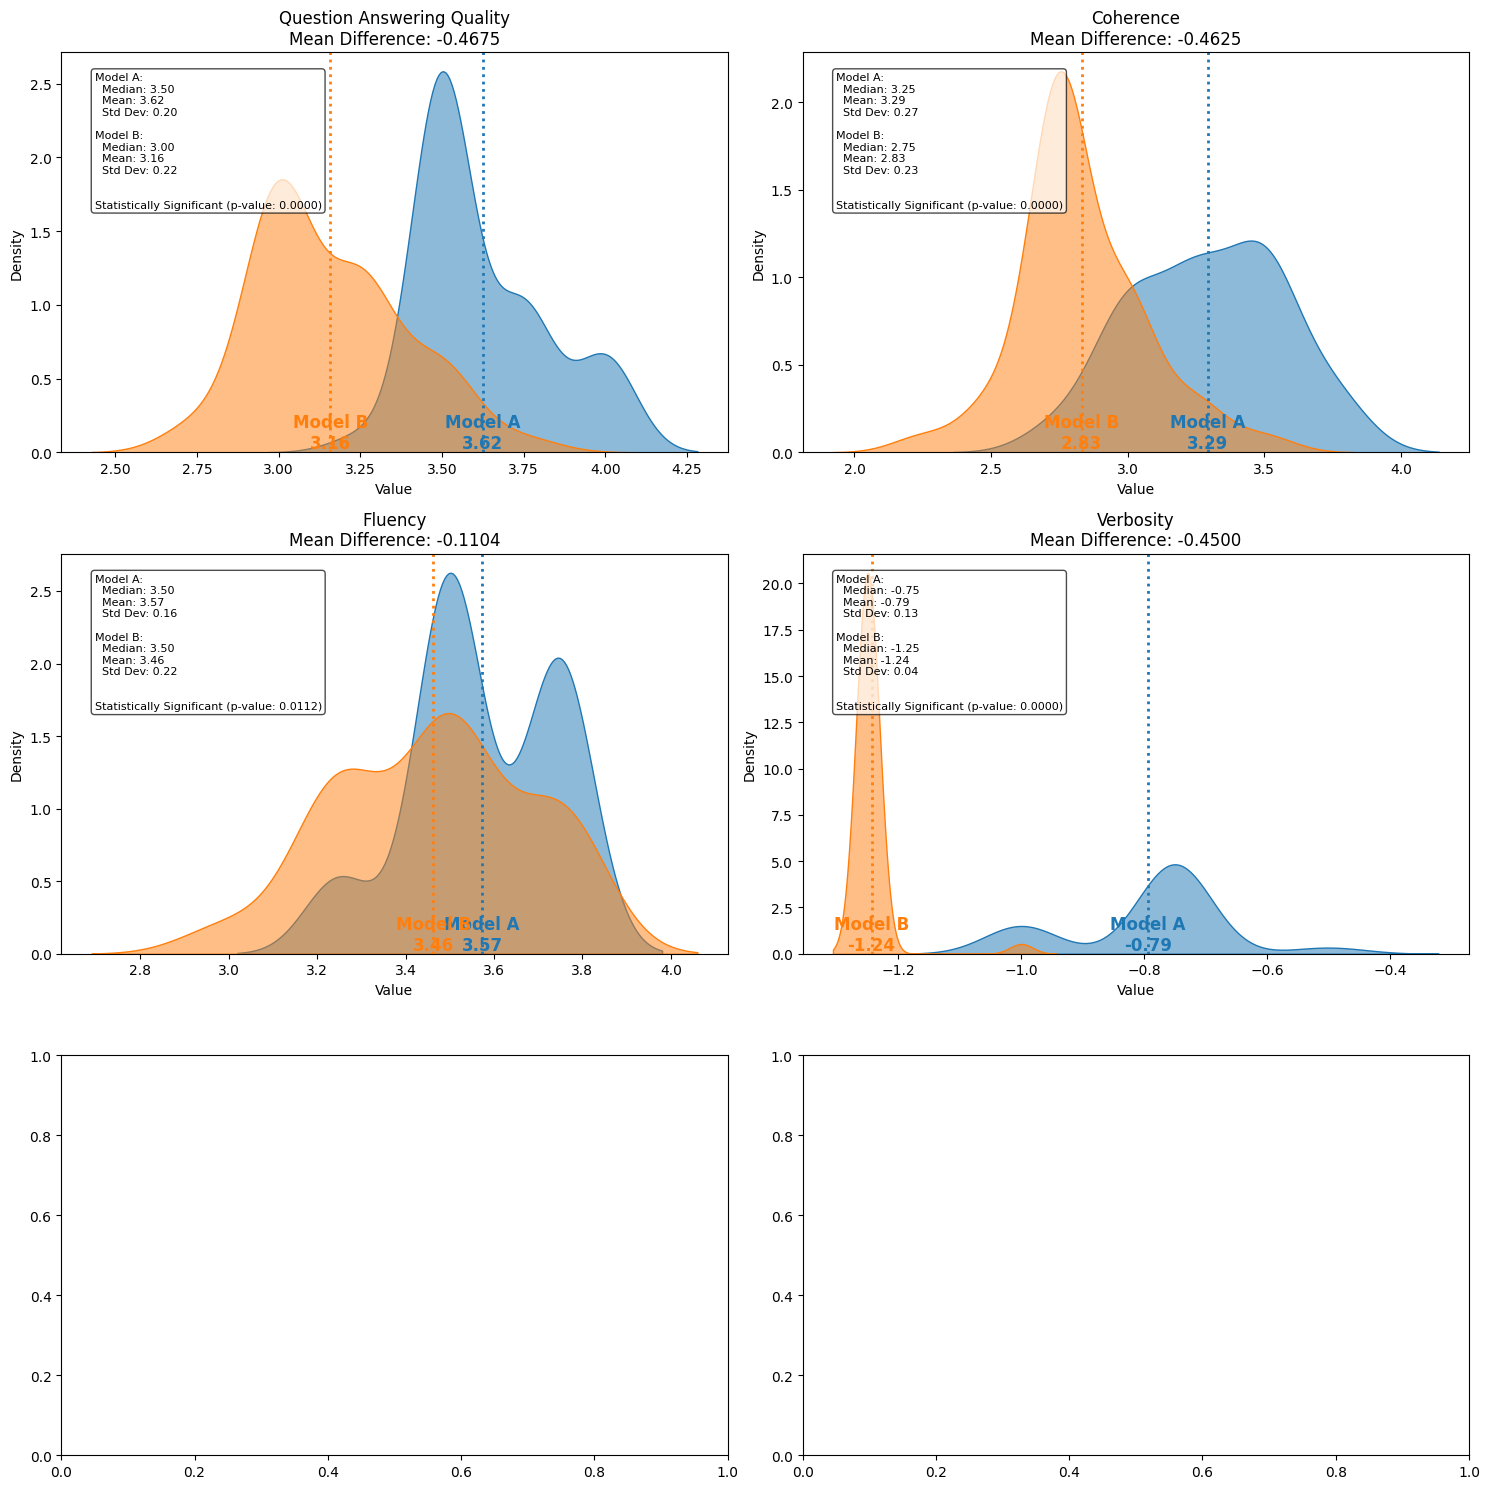

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sample data
dataframes = [model_a_results_df, model_b_results_df]
dataframe_names = ["Model A", "Model B"]


# Create KDE plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# Define a color palette
colors = ['#1f77b4', '#ff7f0e']  # You can add more colors if you have more dataframes

for i, metric in enumerate(mean_metrics):
    row, col = i // 2, i % 2

    means = []
    for df, name, color in zip(dataframes, dataframe_names, colors):
        # Plot KDE
        sns.kdeplot(data=df[metric], ax=axs[row, col], fill=True, alpha=0.5, label=name, color=color)

        # Calculate mean and plot dotted line
        mean_value = df[metric].mean()
        means.append(mean_value)
        axs[row, col].axvline(mean_value, color=color, linestyle=':', linewidth=2)

    # Calculate mean difference and perform t-test
    mean_diff = means[1] - means[0]
    t_stat, p_value = stats.ttest_ind(dataframes[0][metric], dataframes[1][metric])

    title = metric.split('/')[0].replace("_", " ").title()
    diff_title = f"{title}\nMean Difference: {mean_diff:.4f}"
    axs[row, col].set_title(diff_title, fontsize=12)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')


    # Add value labels at the bottom
    ylim = axs[row, col].get_ylim()
    for df, name, color, mean in zip(dataframes, dataframe_names, colors, means):
        axs[row, col].text(mean, ylim[0], f'{name}\n{mean:.2f}', color=color,
                           ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Add text annotations
    stats_text = ""
    for df, name in zip(dataframes, dataframe_names):
        median = df[metric].median()
        mean = df[metric].mean()
        std = df[metric].std()
        stats_text += f'{name}:\n  Median: {median:.2f}\n  Mean: {mean:.2f}\n  Std Dev: {std:.2f}\n\n'

    # Add statistical significance information
    if p_value < 0.02:
        sig_text = f"Statistically Significant (p-value: {p_value:.4f})"
    else:
        sig_text = f"Not Statistically Significant (p-value: {p_value:.4f})"

    stats_text += f"\n{sig_text}"

    axs[row, col].text(0.05, 0.95, stats_text,
                       transform=axs[row, col].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                       fontsize=8)

# Remove extra subplot
if len(metrics) % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

These charts illustrate the performance of the two models across various metrics.  Model A generally demonstrates better quality, verbosity, and coherence than Model B. However, there is no statistically significant difference between the models in terms of fluency.

**Note:** We can evidence that sometimes the normal distribution is not as clear as other times, that is why is important to look at the charts before making any definitive conclusion

#**Comparing Results**

Now we can plot a more general overlapping view using a radar chart to understand in which areas the approaches differ

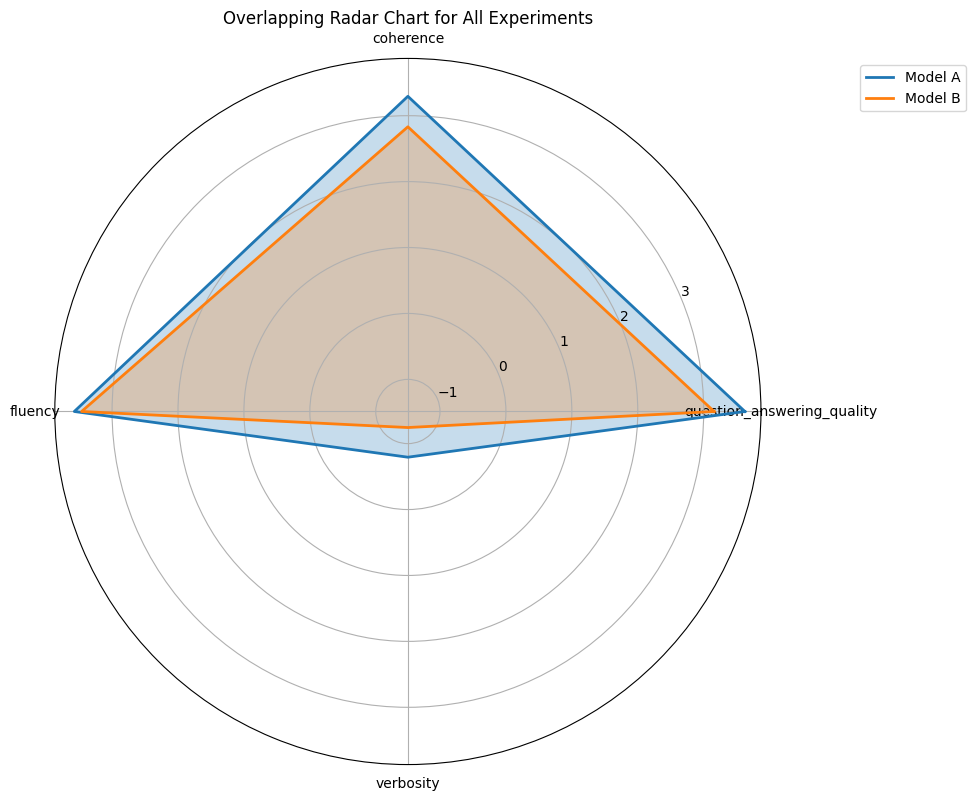

In [51]:
# Function to create radar chart
def radar_chart(data, title):
    angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
    values = data[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# # Create radar charts for each dataframe
# for df, name in zip(dataframes, dataframe_names):
#     radar_chart(df, f'Radar Chart for {name}')

# Create overlapping radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

for df, name in zip(dataframes, dataframe_names):
    values = df[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    ax.plot(angles, values, linewidth=2, label=name)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
ax.set_title('Overlapping Radar Chart for All Experiments')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we demonstrated the power of statistical analysis in understanding the performance of non-deterministic eval tasks. By leveraging techniques like the independent samples t-test, we moved beyond single-run observations to gain a more comprehensive understanding of the variability and underlying trends in our results.

The insights gleaned from this analysis can inform future iterations of the eval task, guide decision-making based on statistically sound evidence, and pave the way for more robust and reliable evaluations in the face of inherent uncertainty.

Note: The purpose of this analysis is not to have a rigorous statistical proof (since we are making a lot of assumptions), but to gain a more holistic view of the architecture's performance